# 02. NFL Team Style Clustering (Static, Season-Level)

**Goal:**  
Build season-level team style clusters (e.g., Balanced, Offense-heavy, Struggling) using team-season EPA and performance metrics.

**Contents:**  
- Load `team_season_epa_2019_2024.csv`  
- Standardize numeric features  
- K-Means clustering (3 clusters recommended)  
- Visualize cluster differences and interpretability  
- Assign each team-season a style label  

**Output File Saved:**  
- `data/processed/team_season_clusters_2019_2024.csv`  

This file provides “static priors” used later in the win prediction model (Notebook 04).

# 2.  Imports and Project Paths (Code)

In [19]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set(style="whitegrid")
except ImportError:
    sns = None

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set absolute project paths (adjust if your path is different)
BASE_DIR = Path("/Users/minseobeom/Desktop/nfl-epa-analysis")

DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"

print("BASE_DIR     :", BASE_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)

BASE_DIR     : /Users/minseobeom/Desktop/nfl-epa-analysis
PROCESSED_DIR: /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed


# 3.  Load Team-Season EPA Data (Code)

In [20]:
# 1. Load team-season EPA data

EPA_FILE = PROCESSED_DIR / "team_season_epa_2019_2024.parquet"

team_season_epa = pd.read_parquet(EPA_FILE)
print("Shape:", team_season_epa.shape)
team_season_epa.head()

Shape: (192, 7)


,season,team,off_plays,off_epa_sum,off_epa_mean,def_plays,def_epa_mean
0,2019,ARI,1321,-29.075460,-0.022010,1418,0.044271
1,2019,ATL,1434,-12.499887,-0.008717,1309,0.004228
2,2019,BAL,1471,187.738037,0.127626,1316,-0.059588
3,2019,BUF,1437,-57.080254,-0.039722,1383,-0.092847
4,2019,CAR,1402,-118.092926,-0.084232,1378,0.033184


# 4. Select Clustering Features (Code)

In [21]:
# 2. Select features for clustering
# We start with two core metrics:
# - off_epa_mean: offensive EPA per play
# - def_epa_mean: defensive EPA allowed per play

features = ["off_epa_mean", "def_epa_mean"]

X = team_season_epa[features].copy()
print("Selected features:")
X.head()

Selected features:


,off_epa_mean,def_epa_mean
0,-0.022010,0.044271
1,-0.008717,0.004228
2,0.127626,-0.059588
3,-0.039722,-0.092847
4,-0.084232,0.033184


# 5. Standardize Features (Code)

In [22]:
# 3. Standardize features (important for KMeans)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)
X_scaled[:5]

Scaled shape: (192, 2)


array([[-1.9722082e-01,  9.5046866e-01],
       [-1.7909672e-03,  1.8086867e-01],
       [ 2.0026243e+00, -1.0456587e+00],
       [-4.5760444e-01, -1.6848892e+00],
       [-1.1119573e+00,  7.3738074e-01]], dtype=float32)

# 6. Try Multiple k Values with Silhouette Score (Code)

In [23]:
# 4. Evaluate KMeans with several values of k

results = []

for k in range(3, 7):  # k = 3, 4, 5, 6
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    results.append((k, sil))

results_df = pd.DataFrame(results, columns=["k", "silhouette"])
results_df

,k,silhouette
0,3,0.342139
1,4,0.348662
2,5,0.357822
3,6,0.372377


# 7. Fit Final KMeans Model (Code)

In [24]:
# 5. Fit final KMeans model with chosen k

FINAL_K = 4  # update this based on the results above
kmeans = KMeans(n_clusters=FINAL_K, n_init=10, random_state=42)

cluster_labels = kmeans.fit_predict(X_scaled)
team_season_epa["cluster"] = cluster_labels

print("Clustered data shape:", team_season_epa.shape)
team_season_epa.head()

Clustered data shape: (192, 8)


,season,team,off_plays,off_epa_sum,off_epa_mean,def_plays,def_epa_mean,cluster
0,2019,ARI,1321,-29.075460,-0.022010,1418,0.044271,2
1,2019,ATL,1434,-12.499887,-0.008717,1309,0.004228,2
2,2019,BAL,1471,187.738037,0.127626,1316,-0.059588,1
3,2019,BUF,1437,-57.080254,-0.039722,1383,-0.092847,0
4,2019,CAR,1402,-118.092926,-0.084232,1378,0.033184,2


# 8. Cluster Summary Table (Code)

In [25]:
# 6. Summarize cluster profiles

cluster_summary = (
    team_season_epa
    .groupby("cluster")
    .agg(
        mean_off_epa=("off_epa_mean", "mean"),
        mean_def_epa=("def_epa_mean", "mean"),
        team_seasons=("team", "count"),
    )
    .reset_index()
)

cluster_summary

,cluster,mean_off_epa,mean_def_epa,team_seasons
0,0,-0.082562,-0.042162,44
1,1,0.030843,-0.044848,57
2,2,-0.031707,0.039919,66
3,3,0.092685,0.031275,25


### Cluster interpretation (k = 4)

Based on the cluster means, we can interpret the four team-style clusters as follows:

- **Cluster 0 – Defense-first, offense-limited**
  - `mean_off_epa ≈ -0.08` (below-average offensive efficiency)
  - `mean_def_epa ≈ -0.04` (above-average defensive efficiency)
  - Teams that rely on defense to stay competitive, with weaker offenses.

- **Cluster 1 – Balanced strong teams**
  - `mean_off_epa ≈ +0.03` (solid offense)
  - `mean_def_epa ≈ -0.04` (solid defense)
  - Well-rounded contenders with above-average performance on both sides of the ball.
  - Example: 2019 BAL falls into this group.

- **Cluster 2 – Struggling on both sides**
  - `mean_off_epa ≈ -0.03` (underperforming offense)
  - `mean_def_epa ≈ +0.04` (defense that allows positive EPA to opponents)
  - Teams that are below average on both offense and defense; often rebuilding or bottom-tier seasons.

- **Cluster 3 – Offense-driven / shootout teams**
  - `mean_off_epa ≈ +0.09` (high-powered offense)
  - `mean_def_epa ≈ +0.03` (leaky defense)
  - Teams that win (or lose) through shootouts: explosive on offense but vulnerable on defense.

# 9. Offense vs Defense EPA Cluster Plot (Code)

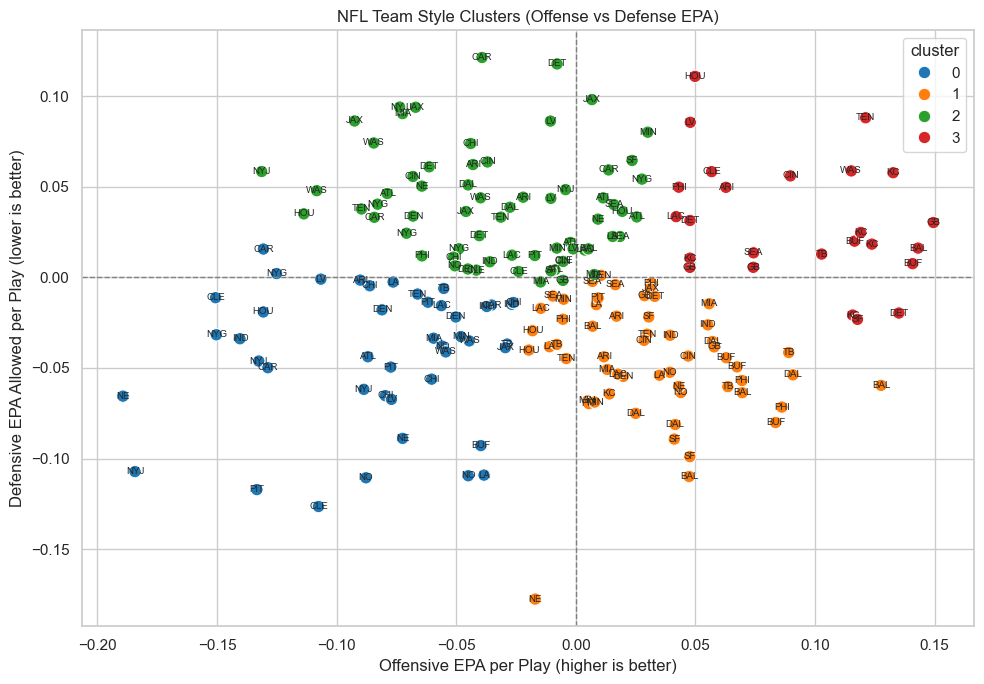

In [26]:
# 7. Visualize clusters on offense vs defense EPA map

plt.figure(figsize=(10, 7))

if sns:
    ax = sns.scatterplot(
        data=team_season_epa,
        x="off_epa_mean",
        y="def_epa_mean",
        hue="cluster",
        palette="tab10",
        s=80
    )
else:
    # Fallback if seaborn is not available
    for c in sorted(team_season_epa["cluster"].unique()):
        sub = team_season_epa[team_season_epa["cluster"] == c]
        plt.scatter(sub["off_epa_mean"], sub["def_epa_mean"], label=f"cluster {c}")
    plt.legend(title="cluster")

# Add team labels
for _, row in team_season_epa.iterrows():
    plt.text(
        row["off_epa_mean"],
        row["def_epa_mean"],
        row["team"],
        fontsize=7,
        ha="center",
        va="center"
    )

plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.axhline(0, linestyle="--", color="gray", linewidth=1)

plt.title("NFL Team Style Clusters (Offense vs Defense EPA)")
plt.xlabel("Offensive EPA per Play (higher is better)")
plt.ylabel("Defensive EPA Allowed per Play (lower is better)")
plt.tight_layout()
plt.show()

### Cluster Visualization Interpretation

The scatter plot shows the distribution of all team-seasons from 2019–2024 on a two-dimensional EPA landscape:

- **X-axis: Offensive EPA per Play (higher = better offense)**
- **Y-axis: Defensive EPA Allowed per Play (lower = better defense)**

Each cluster forms a distinct region:

1. **Cluster 0 — Defense-first teams (bottom-left)**  
   Weak offense (negative EPA) but strong defenses (negative allowed EPA).  
   Typical low-scoring, defense-driven profiles.

2. **Cluster 1 — Balanced strong teams (bottom-right)**  
   Positive offensive EPA and negative defensive EPA.  
   True contenders with strength on both sides of the ball.

3. **Cluster 2 — Struggling teams (top-left)**  
   Negative offensive EPA and positive defensive EPA.  
   Below-average in both areas; often rebuilding or inconsistent teams.

4. **Cluster 3 — Offense-driven teams (top-right)**  
   High-powered offenses but leaky defenses.  
   Shootout-oriented teams with explosive scoring but defensive instability.

## 10. (Optional) Save Clustered Table (Code)

In [27]:
# 8. Save clustered team-season EPA table for later use (optional)

OUT_FILE = PROCESSED_DIR / "team_season_epa_2019_2024_with_clusters.csv"
team_season_epa.to_csv(OUT_FILE, index=False)

print("Saved clustered table to:", OUT_FILE)

Saved clustered table to: /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed/team_season_epa_2019_2024_with_clusters.csv


## Future Work

- Evaluate cluster transitions across seasons (team evolution).
- Use cluster labels as additional input features for a pre-game win probability model.
- Add more metrics beyond EPA (pace, red zone efficiency, explosive plays).

## Add human-readable cluster labels

To make the clusters easier to interpret, we map each numeric cluster ID
to a human-readable label based on its offensive and defensive EPA profile.

In [29]:
# Map numeric cluster IDs to human-readable style names

cluster_name_map = {
    0: "Defense-first",
    1: "Balanced strong",
    2: "Struggling",
    3: "Offense-driven",
}

team_season_epa["cluster_name"] = team_season_epa["cluster"].map(cluster_name_map)

team_season_epa[["season", "team", "off_epa_mean", "def_epa_mean", "cluster", "cluster_name"]].head()

,season,team,off_epa_mean,def_epa_mean,cluster,cluster_name
0,2019,ARI,-0.022010,0.044271,2,Struggling
1,2019,ATL,-0.008717,0.004228,2,Struggling
2,2019,BAL,0.127626,-0.059588,1,Balanced strong
3,2019,BUF,-0.039722,-0.092847,0,Defense-first
4,2019,CAR,-0.084232,0.033184,2,Struggling


## Season-wise cluster composition

- Here we examine how the distribution of team styles changes across seasons.
- For each season, we count how many team-seasons belong to each cluster.

In [30]:
# Count team-seasons per (season, cluster)

season_cluster_counts = (
    team_season_epa
    .groupby(["season", "cluster_name"])
    .size()
    .reset_index(name="count")
)

season_cluster_counts

,season,cluster_name,count
0,2019,Balanced strong,11
1,2019,Defense-first,7
2,2019,Offense-driven,1
3,2019,Struggling,13
4,2020,Balanced strong,7
5,2020,Defense-first,3
6,2020,Offense-driven,8
7,2020,Struggling,14
8,2021,Balanced strong,14
9,2021,Defense-first,6


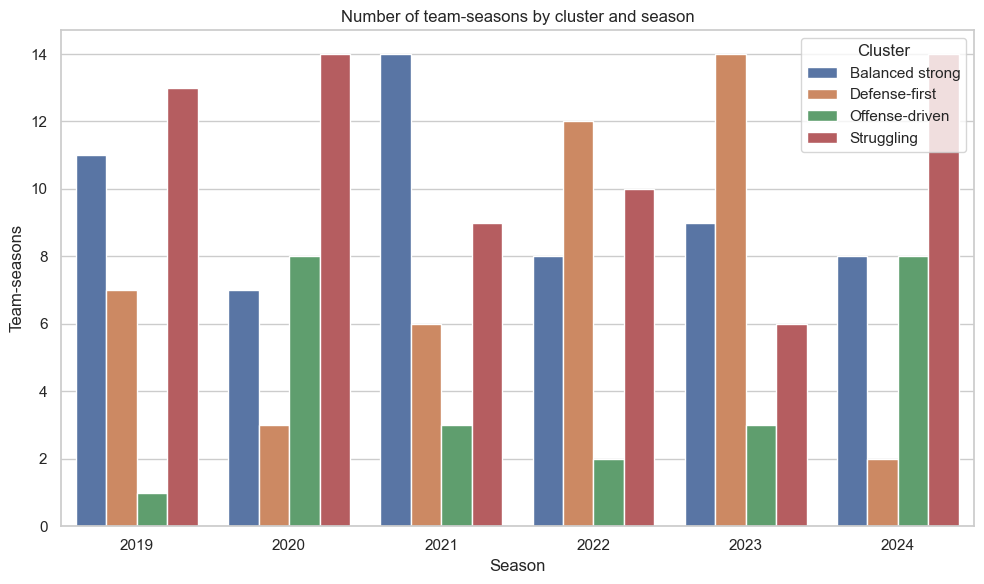

In [31]:
# Plot season-wise cluster counts

plt.figure(figsize=(10, 6))

if sns:
    ax = sns.barplot(
        data=season_cluster_counts,
        x="season",
        y="count",
        hue="cluster_name"
    )
    plt.title("Number of team-seasons by cluster and season")
    plt.ylabel("Team-seasons")
    plt.xlabel("Season")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()
else:
    # Fallback without seaborn
    for name, sub in season_cluster_counts.groupby("cluster_name"):
        plt.plot(sub["season"], sub["count"], marker="o", label=name)
    plt.title("Number of team-seasons by cluster and season")
    plt.ylabel("Team-seasons")
    plt.xlabel("Season")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Team style trajectories over seasons

- To illustrate how team styles evolve over time, we can track the cluster
assignment of a specific team across seasons.  Below is an example for one team.

In [32]:
# Choose a team to inspect (you can change this to "KC", "SF", etc.)
target_team = "BUF"

team_history = (
    team_season_epa
    .loc[team_season_epa["team"] == target_team]
    .sort_values("season")
)

team_history[["season", "team", "off_epa_mean", "def_epa_mean", "cluster", "cluster_name"]]

,season,team,off_epa_mean,def_epa_mean,cluster,cluster_name
3,2019,BUF,-0.039722,-0.092847,0,Defense-first
35,2020,BUF,0.116549,0.020004,3,Offense-driven
67,2021,BUF,0.083549,-0.080112,1,Balanced strong
99,2022,BUF,0.067425,-0.049387,1,Balanced strong
131,2023,BUF,0.062884,-0.044337,1,Balanced strong
163,2024,BUF,0.140825,0.007585,3,Offense-driven


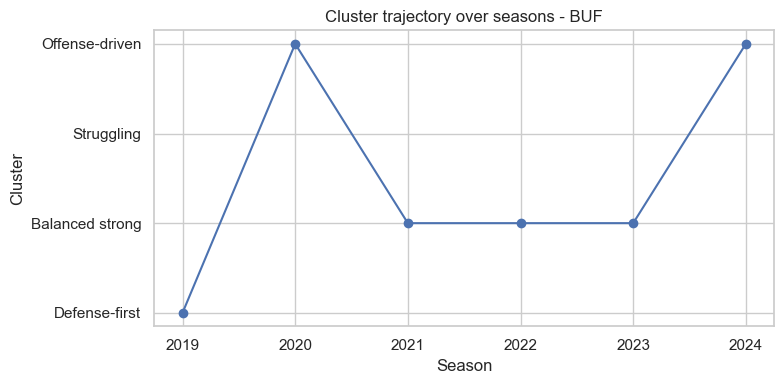

In [33]:
# Plot cluster trajectory across seasons for the selected team

plt.figure(figsize=(8, 4))
plt.plot(team_history["season"], team_history["cluster"], marker="o")

plt.yticks(
    sorted(team_season_epa["cluster"].unique()),
    [cluster_name_map[c] for c in sorted(team_season_epa["cluster"].unique())]
)

plt.title(f"Cluster trajectory over seasons - {target_team}")
plt.xlabel("Season")
plt.ylabel("Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
for target_team in ["BUF", "KC", "SF"]:
    team_history = (
        team_season_epa
        .loc[team_season_epa["team"] == target_team]
        .sort_values("season")
    )
    print(f"\n=== {target_team} ===")
    display(team_history[["season", "team", "off_epa_mean", "def_epa_mean", "cluster_name"]])


=== BUF ===


,season,team,off_epa_mean,def_epa_mean,cluster_name
3,2019,BUF,-0.039722,-0.092847,Defense-first
35,2020,BUF,0.116549,0.020004,Offense-driven
67,2021,BUF,0.083549,-0.080112,Balanced strong
99,2022,BUF,0.067425,-0.049387,Balanced strong
131,2023,BUF,0.062884,-0.044337,Balanced strong
163,2024,BUF,0.140825,0.007585,Offense-driven



=== KC ===


,season,team,off_epa_mean,def_epa_mean,cluster_name
15,2019,KC,0.115742,-0.020798,Offense-driven
47,2020,KC,0.132693,0.057777,Offense-driven
79,2021,KC,0.119135,0.024798,Offense-driven
111,2022,KC,0.123786,0.018357,Offense-driven
143,2023,KC,0.014037,-0.064324,Balanced strong
175,2024,KC,0.047757,0.010613,Offense-driven



=== SF ===


,season,team,off_epa_mean,def_epa_mean,cluster_name
28,2019,SF,0.047685,-0.098922,Balanced strong
60,2020,SF,-0.010385,0.003586,Struggling
92,2021,SF,0.030502,-0.021816,Balanced strong
124,2022,SF,0.041176,-0.089233,Balanced strong
156,2023,SF,0.117767,-0.023174,Offense-driven
188,2024,SF,0.023534,0.064548,Struggling


--------
### BUF Style Trajectory (2019–2024) ###

**2019 – Defense-first**  
BUF begins the period as a defense-oriented team. Offensive EPA is slightly negative, while defensive EPA allowed is strongly negative — the classic profile of a team leaning on its defense to stay competitive.

**2020 – Offense-driven breakout**  
In 2020, BUF makes a dramatic jump to the *Offense-driven* cluster. Offensive EPA becomes highly positive, while defensive EPA allowed flips slightly positive.  
This is a classic “shootout” identity — elite offense, more volatile defense.

**2021–2023 – Balanced strong contender**  
For three straight seasons, BUF stabilizes as a *Balanced strong* team. Offense remains above league average, and defensive EPA allowed is comfortably negative.  
This period reflects BUF’s identity as a well-rounded contender.

**2024 – Offense-driven again**  
In 2024, BUF returns to the *Offense-driven* cluster with its highest offensive EPA in the dataset. Defense becomes slightly positive again, suggesting a shift toward an even more aggressive, offense-first identity.

**Summary**  
BUF’s trajectory is a clear progression through four identities:
- Defense-first foundation  
- Explosive offense breakout  
- Contender-level balance  
- High-variance offense dominance  

This is exactly the type of structural evolution that the style model is designed to capture.

---------

### KC Style Trajectory (2019–2024)

**2019–2022 – Persistent Offense-driven identity**  
KC enters 2019 with a strongly positive offensive EPA and stays in the *Offense-driven* cluster for four consecutive seasons.  
This reflects one of the most consistent offensive profiles in the league — top-tier offensive efficiency paired with a defense that ranges from neutral to slightly positive EPA allowed.

**2023 – Shift to Balanced strong**  
In 2023, KC dips into the *Balanced strong* cluster.  
Offensive EPA drops significantly compared to prior years, while defensive EPA allowed becomes negative, meaning the defense improved.  
This season represents a rare identity shift:  
→ Less explosive offense, better defense, more balanced overall approach.

**2024 – Return to Offense-driven**  
In 2024, KC climbs back to the *Offense-driven* cluster.  
Offense recovers to positive EPA; defense becomes slightly positive again.  
This suggests a rebound toward their traditional high-powered style.

**Summary**  
KC shows one of the **most stable offensive identities** in the league:  
- Four consecutive offense-driven seasons  
- One-year shift to a defense-improved, balanced profile  
- Quick return to offense-based play  
This makes KC one of the most consistent high-level offenses in the dataset.

----------

### SF Style Trajectory (2019–2024)

**2019 – Balanced strong**  
SF opens with positive offensive EPA and strongly negative defensive EPA allowed, placing them in the *Balanced strong* cluster — a contender-level profile.

**2020 – Struggling season**  
In 2020, both offensive EPA and defensive EPA allowed regress toward zero and positive values.  
SF drops into the *Struggling* cluster — below average on both sides.

**2021–2022 – Return to Balanced strong**  
SF recovers quickly.  
Both seasons show solid offensive EPA and notably negative defensive EPA allowed, recreating their balanced contender identity.

**2023 – Offense-driven peak**  
In 2023, SF posts highly positive offensive EPA alongside slightly negative defensive EPA allowed.  
This is their strongest offensive profile in the sample, moving them into the *Offense-driven* cluster.

**2024 – Sharp decline to Struggling**  
Offensive EPA drops close to zero and defensive EPA allowed becomes highly positive.  
SF falls back into the *Struggling* cluster — a major step down compared to 2023.

**Summary**  
SF’s identity is highly volatile across these six seasons:
- Balanced contender → collapse → balanced again → elite offense → collapse  
This makes SF the **most identity-shifting team** among the three examples.
_________

## EPA distributions by cluster

We now compare the distributions of offensive and defensive EPA across clusters
to verify that each style group is statistically distinct.

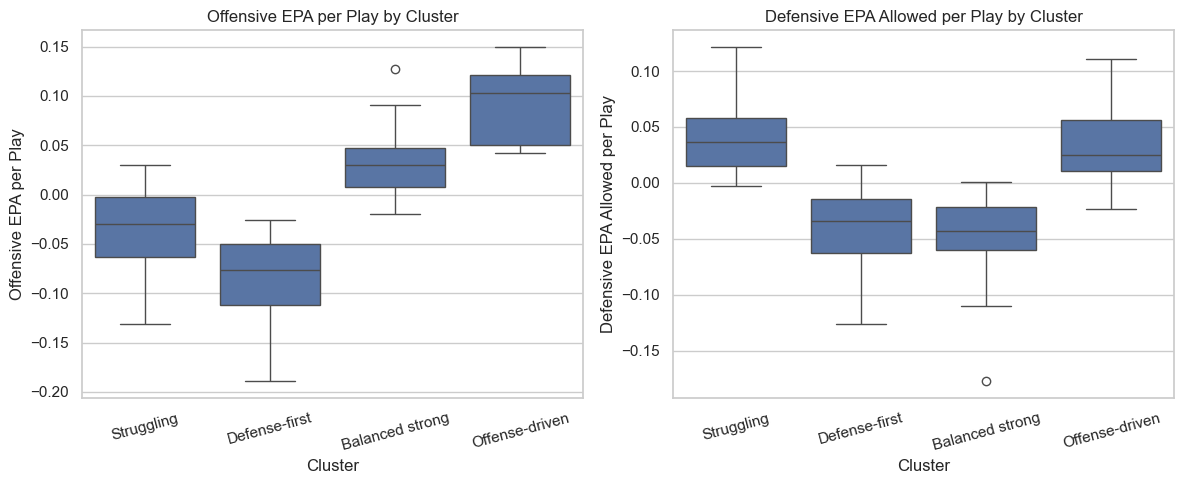

In [35]:
# Boxplots for offensive and defensive EPA by cluster

if sns:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=team_season_epa,
        x="cluster_name",
        y="off_epa_mean",
        order=["Struggling", "Defense-first", "Balanced strong", "Offense-driven"]
    )
    plt.title("Offensive EPA per Play by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Offensive EPA per Play")
    plt.xticks(rotation=15)

    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=team_season_epa,
        x="cluster_name",
        y="def_epa_mean",
        order=["Struggling", "Defense-first", "Balanced strong", "Offense-driven"]
    )
    plt.title("Defensive EPA Allowed per Play by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Defensive EPA Allowed per Play")
    plt.xticks(rotation=15)

    plt.tight_layout()
    plt.show()
else:
    print("Seaborn is not available; skipping boxplots.")

## Representative seasons for each cluster

Finally, we extract some representative team-seasons from each cluster.
For offense-driven teams, we pick seasons with the highest offensive EPA.
For defense-first teams, we pick seasons with the lowest defensive EPA allowed.

In [36]:
# Top offensive seasons within the "Offense-driven" cluster

offense_driven = team_season_epa[team_season_epa["cluster_name"] == "Offense-driven"]

top_offense_seasons = (
    offense_driven
    .sort_values("off_epa_mean", ascending=False)
    [["season", "team", "off_epa_mean", "def_epa_mean", "cluster_name"]]
    .head(10)
)

print("Top offensive seasons within Offense-driven cluster:")
top_offense_seasons

Top offensive seasons within Offense-driven cluster:


,season,team,off_epa_mean,def_epa_mean,cluster_name
43,2020,GB,0.149553,0.030288,Offense-driven
162,2024,BAL,0.143104,0.016175,Offense-driven
163,2024,BUF,0.140825,0.007585,Offense-driven
170,2024,DET,0.135084,-0.019676,Offense-driven
47,2020,KC,0.132693,0.057777,Offense-driven
111,2022,KC,0.123786,0.018357,Offense-driven
62,2020,TEN,0.121180,0.088121,Offense-driven
79,2021,KC,0.119135,0.024798,Offense-driven
156,2023,SF,0.117767,-0.023174,Offense-driven
35,2020,BUF,0.116549,0.020004,Offense-driven


--------

### Top offensive seasons within the offense-driven cluster

The list above shows the ten highest offensive EPA per play seasons among all
team-seasons classified as *Offense-driven*.

Several well-known explosive offenses appear here (e.g., GB 2020, KC 2020–2022,
BUF 2020/2024, TEN 2020). All of these seasons post an offensive EPA per play
above +0.11, with the very top entries reaching +0.14–0.15, which corresponds
to truly elite, Super Bowl–caliber offensive efficiency.

Defensive EPA allowed varies across these seasons:

- Some teams combine elite offense with weak defense (e.g., KC 2020, TEN 2020),
  winning through shootouts.
- Others, such as DET 2024 or SF 2023, pair top-tier offense with at least
  respectable defense, forming complete high-end contenders.
- Teams like BUF or BAL sit in between, with average defenses and offenses that
  carry most of the load.

This table confirms that the Offense-driven cluster is not just a statistical
artifact: it captures exactly the offenses that fans and analysts already
recognize as the most explosive units in recent NFL seasons.

-----------

In [37]:
# Top defensive seasons within the "Defense-first" cluster
# (lowest def_epa_mean = best defenses)

defense_first = team_season_epa[team_season_epa["cluster_name"] == "Defense-first"]

top_defense_seasons = (
    defense_first
    .sort_values("def_epa_mean", ascending=True)
    [["season", "team", "off_epa_mean", "def_epa_mean", "cluster_name"]]
    .head(10)
)

print("Top defensive seasons within Defense-first cluster:")
top_defense_seasons

Top defensive seasons within Defense-first cluster:


,season,team,off_epa_mean,def_epa_mean,cluster_name
135,2023,CLE,-0.107592,-0.126473,Defense-first
26,2019,PIT,-0.133364,-0.117138,Defense-first
86,2021,NO,-0.087743,-0.110614,Defense-first
150,2023,NO,-0.044961,-0.109493,Defense-first
48,2020,LA,-0.038378,-0.109127,Defense-first
152,2023,NYJ,-0.184332,-0.107195,Defense-first
3,2019,BUF,-0.039722,-0.092847,Defense-first
117,2022,NE,-0.072419,-0.088864,Defense-first
146,2023,LV,-0.077089,-0.067304,Defense-first
149,2023,NE,-0.189340,-0.065546,Defense-first


-----

### Top defensive seasons within the Defense-first cluster

The table above lists the ten seasons with the lowest defensive EPA allowed
among all team-seasons classified as *Defense-first*.

These defenses are truly elite: values around −0.10 to −0.13 EPA allowed per play
correspond to some of the best units in recent NFL history, such as CLE 2023,
PIT 2019, NO 2021/2023, and LAR 2020. In contrast, their offenses are clearly
below average, with offensive EPA per play consistently in the negative range.

This pattern captures the essence of the Defense-first cluster:
teams that field dominant defenses but struggle to move the ball on offense.
Many of these seasons match how fans and analysts remember these teams in
context — for example, “great defense, painful offense” for NYJ 2023 or NE 2023.

-------